In [1]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU'
device_name = 'CPU' 
print(f'device name {device_name}')
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree


import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

import GenerateEndpoints as ge
import matplotlib.pyplot as plt

import copy
import Guided_Midpoint_Buttress as gmp

device name CPU
device name CPU


In [2]:
def add_loops(end_points, neighbors=10, length_mod=1, dist_cut=6, phiQueryNum=10, randMult=10, maxPhi_cut=20,
              uniquePhi=True, verbose=False, maxReruns = 4):
    """Chains first_helix, first_loop, second helix and the iteratively loop_then_helix to add all loops to endpoints."""
    
    epIn = end_points.copy()
    size = int(len(epIn)/2) #number of helixes represented by helical endpoints
    
   
    bL, iL, epGuide = le.first_helix(epIn,length_mod=length_mod)
    if verbose:
        print(f'first helix: #{iL.shape[0]}')
    
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    bL, iL, epGuide, epTrue, phiList, loopFeature, xform_True = le.first_loop(bL, iL, epGuide, 
                                                                neighbors=neighbors, phiQueryNum=phiQueryNum,
                                                                           randMult=randMult, distCut=dist_cut)
    if verbose:
        print(f'first loop: #{iL.shape[0]}')
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    hnum=1
    bL, iL, epGuide, epTrue, phiList = le.second_helix(bL, iL, epGuide, epTrue, phiList, hnum, loopFeature, 
                                                   xform_True, length_mod=length_mod, distCut=dist_cut)
    if verbose:
        print(f'second helix: #{iL.shape[0]}')
    
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    repeatNumber = 0 
    hnum = 0
    
    bL_s = []
    iL_s = []
    epGuide_s = []
    epTrue_s = []
    phiList_s =  []
    for x in range(0,(size-1)):
        bL_s.append([])
        iL_s.append([])
        epGuide_s.append([])
        epTrue_s.append([])
        phiList_s.append([])
        
    
    while hnum<(size-2):
        hnum += 1
        print('hnum',hnum)
        bL, iL, epGuide, epTrue, phiList = le.next_loop_helix(bL, iL, epGuide, epTrue, phiList, hnum, 
                neighbors=neighbors, phiQueryNum=phiQueryNum, randMult=randMult, distCut=dist_cut,length_mod=length_mod)
       
        bL_s[hnum] = copy.deepcopy(bL)
        iL_s[hnum] = iL.copy()
        epGuide_s[hnum] = epGuide.copy()
        epTrue_s[hnum] = epTrue.copy()
        phiList_s[hnum] = phiList.copy()
        
        if iL.shape[0] == 0:
            
            hnum = hnum - 2
            
            bL = bL_s[hnum] 
            iL = iL_s[hnum] 
            epGuide = epGuide_s[hnum] 
            epTrue = epTrue_s[hnum] 
            phiList = phiList_s[hnum] 
            
            neighbors += 5
            maxPhi_cut += 100
            
            repeatNumber += 1
            print('rn:', repeatNumber)
                
            if repeatNumber == maxReruns:
                if verbose:
                    print('fail2')
                return bL, iL, phiList, iL, iL, False
            
        if iL.shape[0] > maxPhi_cut:
            indexer = le.random_reduce(bL,num_to_keep = maxPhi_cut)
            bL = bL[indexer]
            iL = iL[indexer] 
            epGuide = epGuide[indexer]
            epTrue =  epTrue[indexer]
            phiList = phiList[indexer]
            if verbose:
                print(f'{hnum+2} helix: reduced to #{maxPhi_cut}')
        if verbose:
            print(f'{hnum+2} helix: #{iL.shape[0]}')
            
         
    #only return proteins with a unique set of loops queried from different phi bins
    if uniquePhi:
        phiList, u_indices = np.unique(phiList,axis=0,return_index=True)
        epGuide = epGuide[u_indices]
        epTrue = epTrue[u_indices]
        iL = iL[u_indices]
        bL = bL[u_indices]
    
    return bL, iL, phiList, epGuide, epTrue, True

In [3]:
#generate guide points

def generate_parabola(start, stop, h=[20,20,20], k=[20,30,40], num_points = 100):
    #create a set of parabolas past through ([0,0]) start of helices to vertex ([[10,20],[10,30],[10,40]])
    # (x-h)^2 = -4(a)(y-k)
    # Solve for 'a' at x=0, y=0
    # (0-h)^2 = -4(a)(0-k)
    #      a  =  h^2/4k
    h = np.array(h).reshape((-1,1))
    k = np.array(k).reshape((-1,1))
    a = np.square(h)/(4*k)
    
    #trace x from 0 to 10
    # -4ay +4ak = (x-h)^2
    # -4ay = (x-h)^2 - 4ak
    #    y = ( (x-h)^2 - 4ak  ) / (-4a)
    #    y = (4ak - (x-h)^2)
    x = np.repeat(np.expand_dims(np.linspace(start,stop,num=100), axis=0), h.shape[0],axis=0)
    z = np.divide(4*a*k -np.square(x-h), (4*a))
   
    x=np.expand_dims(x,axis=2)
    z=np.expand_dims(z,axis=2)
    y = np.zeros_like(x)
    gen_para =  np.concatenate((x,y,z),axis = 2)
    
    return gen_para
    
#rotate parabola around the x axis
# angleDeg = 90
# gpi = 1
# xfr=nu.xform_from_axis_angle_deg([1,0,0],angleDeg)
# gp = np.hstack((g_para[gpi],np.ones_like(g_para[gpi,:,gpi].reshape((-1,1)))  ))
# gp_z=nu.xform_npose(xfr,gp)[:,:3]
# gp_z.shape

# plt.scatter(gp_z[:,0], gp_z[:,2], alpha=0.5)
# plt.axis('equal')
# plt.show()


def generate_pos_circle(start, stop, h=30, k=0, r=30, num_points= 100):
    """Generate guide points originating a the origin for a circle, positive values only. """
    #(x-h)^2 + (y-k)^2 = r^(2)
    # y = sqrt(r^2-(x-h^2))+k
    x = np.linspace(start,stop,num=num_points)
    z = np.sqrt(np.square(r)-np.square(x-h))+k
    y = np.zeros_like(x)
    return np.concatenate((x.reshape((-1,1)),y.reshape((-1,1)),z.reshape((-1,1))),axis=1)

def add_xline(inputP, line_length, num=60):
    line = np.zeros((num,3))
    line[:,0] = np.linspace(0, line_length, num=num)
    cline = inputP[-1]+line
    ci_line = np.concatenate((inputP,cline),axis=0)
    
    return ci_line

circ_gp = generate_pos_circle(0,60,h=60,k=0,r=60, num_points= 200)
ci_line = add_xline(circ_gp[:-1], 20, num=60)

In [4]:
# nump = 100
# ini = np.zeros((nump,3))

# ini[:20,2] = np.linspace(0,20,num=20)
# ini[20:,2] = 20
# ini[20:,1] = np.linspace(0,40,num=80)

In [5]:
start_hel = gmp.get_reference_input(batch=3000)

In [6]:
%%time
out_ep = gmp.build_protein_on_guide_clash(start_hel, circ_gp, batch=10, 
                                 next_mp_dist=9, mp_deviation_limit = 5,maxOut=1000,maxClash_num=5)

max next indices 2
(3000, 8, 3)
Input Size:  300000
Passing Filters:  1000
clash keep 901
final pass filter 901
max next indices 12
(901, 8, 3)
Input Size:  90100
Passing Filters:  1000
clash keep 490
final pass filter 490
max next indices 28
(490, 8, 3)
Input Size:  49000
Passing Filters:  1000
clash keep 270
final pass filter 270
max next indices 46
(270, 8, 3)
Input Size:  27000
Passing Filters:  1000
clash keep 308
final pass filter 308
max next indices 67
(308, 8, 3)
Input Size:  30800
Passing Filters:  1000
clash keep 290
final pass filter 290
max next indices 98
(290, 8, 3)
Input Size:  29000
Passing Filters:  940
clash keep 132
final pass filter 132
max next indices 123
(132, 8, 3)
Input Size:  13200
Passing Filters:  320
clash keep 95
final pass filter 95
max next indices 154
(95, 8, 3)
Input Size:  9500
Passing Filters:  266
clash keep 44
final pass filter 44
max next indices 189
(44, 8, 3)
Input Size:  4400
Passing Filters:  167
clash keep 70
final pass filter 70
max next in

In [7]:
%%time
# circ_gp = generate_pos_circle(0,60,h=60,k=0,r=60, num_points= 200)
# ci_line = add_xline(circ_gp, 20, num=60)
# out_ep = gmp.build_protein_on_guide(start_hel, ci_line, batch=400, 
#                                  next_mp_dist=10, mp_deviation_limit = 5,maxOut=1000)


# out_ep = gmp.build_protein_on_guide(start_hel, ci_line, batch=50, 
#                                  next_mp_dist=10, mp_deviation_limit = 5,maxOut=1000)

Wall time: 0 ns


In [7]:
sumL = 0

for i,x in enumerate(out_ep):
    sumL += len(x)
    print(i, len(x))
print('total',sumL)

0 64
1 2
total 66


In [8]:
gmp.vp(out_ep[0],circ_gp,max_out=100)

 PyMOL not running, entering library mode (experimental)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. ]),
 <BarContainer object of 10 artists>)

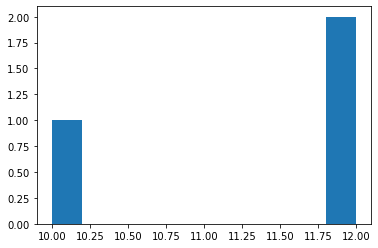

In [31]:
import LoopEndpoints as le
#code to 
epr = ge.EP_Recon(out_ep[0])
eprn = epr.to_npose()
hll = np.array(epr.helixLength_list)
hll.shape
clash_num = []
for x in range(len(eprn)):
    clash_num.append(le.whole_prot_clash_check(eprn[x],hll[x]))
plt.hist(clash_num)   

In [17]:
cn_bon = np.nonzero((clash_num)[0]<16)

In [18]:
cn_bon

(array([0], dtype=int64),)

In [9]:
import LoopEndpoints as le
end_points = out_ep[0][0]
length_mod=1
dist_cut=6
phiQueryNum=10
neighbors = 10
randMult=10
maxPhi_cut=20
verbose= True

In [10]:
end_points.shape

(40, 3)

In [21]:
%%time
bL, iL, phiList, epGuide, epTrue, suc= add_loops(end_points, neighbors=20, length_mod=3, dist_cut=6, phiQueryNum=10, randMult=0, maxPhi_cut=60,
              uniquePhi=True, verbose=True, maxReruns=1)

first helix: #7
first loop: #448
second helix: #626
hnum 1
3 helix: reduced to #60
3 helix: #60
hnum 2
4 helix: reduced to #60
4 helix: #60
hnum 3
5 helix: reduced to #60
5 helix: #60
hnum 4
6 helix: reduced to #60
6 helix: #60
hnum 5
7 helix: reduced to #60
7 helix: #60
hnum 6
8 helix: reduced to #60
8 helix: #60
hnum 7
9 helix: reduced to #60
9 helix: #60
hnum 8
10 helix: reduced to #60
10 helix: #60
hnum 9
11 helix: reduced to #60
11 helix: #60
hnum 10
12 helix: reduced to #60
12 helix: #60
hnum 11
13 helix: reduced to #60
13 helix: #60
hnum 12
14 helix: reduced to #60
14 helix: #60
hnum 13
15 helix: reduced to #60
15 helix: #60
hnum 14
16 helix: reduced to #60
16 helix: #60
hnum 15
17 helix: reduced to #60
17 helix: #60
hnum 16
18 helix: reduced to #60
18 helix: #60
hnum 17
19 helix: #43
hnum 18
20 helix: reduced to #60
20 helix: #60
Wall time: 57.7 s


In [16]:
outDirec= 'output/'
x='gamma'
for num,prot in enumerate(bL):
    if num>200:
        break
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

In [17]:
epr = ge.EP_Recon([out_ep[0][0]])
eprn = epr.to_npose()
hll = np.array(epr.helixLength_list)

In [329]:
hf.HelicalProtein.makePointPDB(epGuide[16] ,f'guide.pdb',outDirec='output/')    

1

In [330]:
hf.HelicalProtein.makePointPDB(epTrue[16] ,f'true.pdb',outDirec='output/')    

1

In [20]:
outDirec= 'output/'
nu.dump_npdb(eprn[0],f'{outDirec}buildHel.pdb')

In [58]:
outDirec= 'output/'
x='gu'
for num,prot in enumerate(epGuide):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

In [327]:
epGuide.shape

(200, 52, 4)

In [328]:
len(bL)

200

In [310]:

nu.dump_npdb(bL[121][5*36:],f'{outDirec}build_CircleLine.pdb')

(array([ 1.,  2.,  2.,  0., 20., 18.,  0., 27., 42.,  4.]),
 array([21. , 21.7, 22.4, 23.1, 23.8, 24.5, 25.2, 25.9, 26.6, 27.3, 28. ]),
 <BarContainer object of 10 artists>)

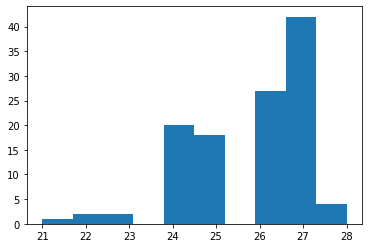

In [ ]:
#correlate this with successful loopings

In [251]:

outDirec= 'output/'
x='beta'
for num,prot in enumerate(eprn):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

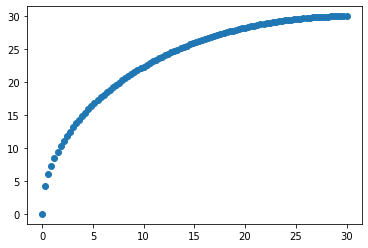

In [26]:
plt.scatter(circ_gp[:,0],circ_gp[:,2])